# SegmentPoints that predicts segment points from x,y
* flipping the segment model to so it trains on x & y and encodes the segment points. A decoder uses the points to predict x & y

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [72]:
# Segment-v4
class SegmentPoint(nn.Module):
    r"""Divides incoming data into segment_features then applies two point
    formula to each segment.
    For any given x only one segment calculates y all others are masked out.
    All x_features (x) contributes in calculation of ever y_feature (y)
    but each combination of x_feature and y_feature has its own set of
    segments. A parameters define segment points. As each segment is connected
    to one or two consecutive segments we get segment_features+1 points per x,y
    This will create total number of
    parameters:
        weights : y_features*x_features*segment_features
        biases  : y_features*x_features*segment_features
    
    logic:
        `y1 = m1x1 + b1` #start of  segment
         y2 = m1x2 + b1  # end of 1st segment
         init:
            initialize segment.xout using xmin,xmax
         encoder: 
            use w & b parameters to calculate segment.y using y1 = wx1 + b
        decoder:
            predict y using segments (as before) and output both y, x
        loss:
            loss is MSE on both x and y output of decoder

    Args:
        x_features: size of each input (x) sample
        y_features: size of each output(y) sample
        segment_features: number of segments on x dimensions

    Shape:
        - Input1: :math:`(*, H_{x})` where :math:`*` means any number of
        dimensions (atleast one) and :math:`H_{x} = \text{x\_features}`.
        - Input2: :math:`(*, H_{y})`  where :math:`*` means any number of
        dimensions (atleast one) and :math:`H_{y} = \text{y\_features}`.
        output1 - x: y_features*x_features*(segment_features+1)
        output2- y: y_features*x_features*(segment_features+1)
        Output3 : Same as Input after decoder

    """
    __constants__ = ['x_features', 'y_features', 'segment_features']
    x_features: int
    y_features: int
    segment_features: int
    w: torch.Tensor
    b: torch.Tensor
    def __init__(self, x_features, y_features, segment_features):
        super(SegmentPoint, self).__init__()
        self.x_features = x_features
        self.y_features = y_features
        self.segment_features = segment_features

        self.w = nn.Parameter(torch.Tensor(x_features,
                                            segment_features, y_features))
        self.b = nn.Parameter(torch.Tensor(x_features,
                                            segment_features, y_features))
        self.xout = torch.Tensor(x_features,
                                            segment_features + 1, y_features)
        self.yout = torch.zeros_like(self.xout)
        # Use initialized flag to ensure custom_init is called before training
        self.initialized = False

    def custom_init(self, x_min, x_max):
        self.initialized = True
        #TODO: Do we need to initialize w & b?
        #self.w = 0.
        #self.b = 0.

        x_init = torch.empty_like(self.xout)
        # _calc_points overerites all xout, except x[0] and x[-1]
        x_init[:,0,:] = x_min
        x_init[0,-1,:] = x_max

        #for i in np.arange(self.x_features):
        #    for j in np.arange(self.y_features):
        #        x_init[i, :, j] = torch.linspace(x_min[i], x_max[i],
        #                            self.segment_features + 1)
        # initialize all rows of x
        self.xout = torch.Tensor(x_init)
        nn.init.normal_(self.w, -10, 10)

    def _encode(self):
        """Calculate segment points from intersects of consecutive segments.
        y = w1x + b1 = w2x + b2
        x = (b2 - b1)/(w1 - w2)
        """
        divider = (self.w[:,:-1,:]-self.w[:,1:,:])
        #The ratio can get -inf or inf. we need to protect against it
        divider[divider == 0.] = 0.0001
        #xout[0] and xout[-1] are never modified.
        self.xout[:,1:-1,:] = (self.b[:,1:,:]-self.b[:,:-1,:])/divider
        self.yout[:,1:-1,:] = self.w[:,:-1,:] * self.xout[:,1:-1,:] + self.b[:,:-1,:]
               
    def _calc_xmask(self, x_in):
        # x_in.shape = [N, in_features]
        self.x_in_4d =  x_in.unsqueeze(-1).unsqueeze(-1)     
        # x_in_4d.shape =  [N, in_features, 1, 1] 
        # to find out if x is between segments
        lt = torch.lt(self.x_in_4d, self.xout[:, 1:, :]) 
        ge = torch.ge(self.x_in_4d, self.xout[:, :-1, :]) 
        xmask = (lt & ge)
        #mask.shape = [N, in_features, segment_features, out_features]

        # This mask doesn't include x where x is below 1st segment start
        # or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(self.x_in_4d,self.xout[:, 0:1, :]) #x less than 1st segment
        # then do OR with mask so these are included for prediction.
        xmask[:,:, 0:1, :] = xmask[:, :, 0:1, :] | mask_lt

        #do the same for last x of segment
        mask_ge = torch.ge(self.x_in_4d,self.xout[:, -1:, :]) 
        xmask[:,:, -1:, :] = xmask[:, :, -1:, :] | mask_ge
        return xmask

    def _decode2(self, x_in):
        """implementation using w & b"""
        xmask = self._calc_xmask(x_in)
        ypred = xmask * self.x_in_4d * self.w  + xmask * self.b
        ypred = torch.sum(ypred, dim=(1,2))
        return ypred

    def _decode(self, x_in):
        xmask = self._calc_xmask(x_in)

        divider = (self.xout[:,1:,:]-self.xout[:,:-1,:])
        #The ratio can get -inf or inf. we need to protect against it
        divider[divider == 0.] = 0.0001

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        ratio = (self.yout[:,1:,:]-self.yout[:,:-1,:])/divider

        ypred = ratio*xmask*(self.x_in_4d - self.xout[:,:-1,:]) + xmask * self.yout[:,:-1,:]
        # ypred.shape = [N, in_features, segment_features, out_features]
        # we can sum up by in_features (as y is cumulative of all f(x))
        # and sum by segment_features (only one segment should be non zero)
        ypred = torch.sum(ypred, dim=(1,2))
        return ypred

    def forward(self, x_in):
        if self.training and not self.initialized:
            raise RuntimeError("model.custom_init was not called before training")
        self._encode()
        ypred = self._decode2(x_in)
        return ypred

    def extra_repr(self) -> str:
        return f'x_features={self.x_features}, y_features={self.y_features}, \
          segment_features={self.segment_features}'
    

# Create Test Dataset

In [4]:
# Define funtions to approximate
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)
    return x_normalized, y_normalized

In [5]:
# Create training dataset
x_in = torch.arange(-1.5, 11., .05)
ytest = f_quartic(x_in)
#normalization - important
x_in, ytest = normalize(x_in, ytest)
print(x_in.shape, ytest.shape)

# Reshape x, ytest to N,1
x_in = x_in.view(x_in.shape[0], 1)
ytest = ytest.reshape(x_in.shape[0], 1)
print(x_in.shape, ytest.shape)

torch.Size([250]) torch.Size([250])
torch.Size([250, 1]) torch.Size([250, 1])


# Model Init

In [90]:
from torch.utils.data import DataLoader

torch.manual_seed(10)

model = SegmentPoint(x_in.shape[1], ytest.shape[1], 4)

#Initialize model parameters - extremely important.
model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.01
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Training loop

In [91]:
num_epochs = 3000
losses = np.array([])
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    losses = np.append(losses, train_loss)
    if epoch % (num_epochs/10) == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

====> Epoch: 300 Average loss: 0.5882
====> Epoch: 600 Average loss: 0.3429
====> Epoch: 900 Average loss: 0.3232
====> Epoch: 1200 Average loss: 0.3126
====> Epoch: 1500 Average loss: 0.2966
====> Epoch: 1800 Average loss: 0.2955
====> Epoch: 2100 Average loss: 0.0152
====> Epoch: 2400 Average loss: 0.0109
====> Epoch: 2700 Average loss: 0.0106
====> Epoch: 3000 Average loss: 0.0118


# Plot model loss, output

last total_mean_loss  0.011750169564038515


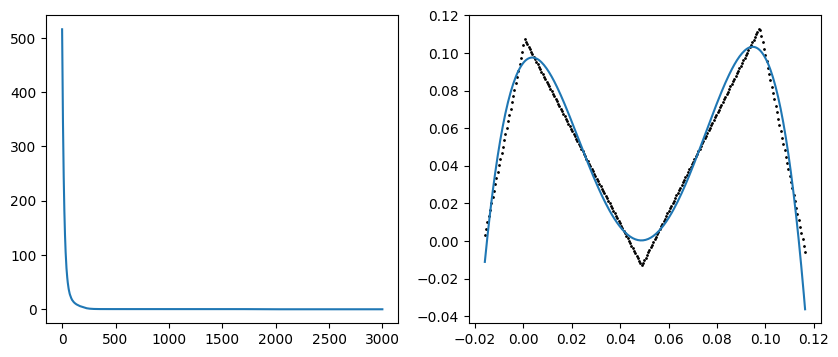

In [92]:
# plot graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",train_loss)
ax1.plot(losses)

# plot trained model
y = model(x_in)
y = y.detach().numpy()
ax2.plot(x_in, ytest)
ax2.scatter(x_in, y, color='black', s=1)

# Display the plot
plt.show()

# Plot segments

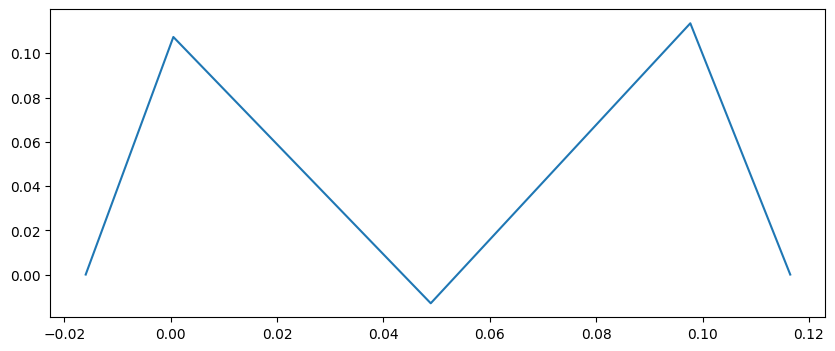

In [93]:
xval = model.xout.reshape(model.xout.shape[1]).detach().numpy()
yval = model.yout.reshape(model.xout.shape[1]).detach().numpy()
plt.plot(xval,yval) 
plt.show()

In [85]:
model.w, model.b

(Parameter containing:
 tensor([[[ 2.4875],
          [-4.0247],
          [ 1.9576],
          [-8.8625]]], requires_grad=True),
 Parameter containing:
 tensor([[[ 0.0785],
          [ 0.1491],
          [-0.0903],
          [ 1.0095]]], requires_grad=True))

In [86]:
model.xout, model.yout


(tensor([[[-0.0160],
          [ 0.0108],
          [ 0.0400],
          [ 0.1016],
          [ 0.1165]]], grad_fn=<AsStridedBackward0>),
 tensor([[[ 0.0000],
          [ 0.1055],
          [-0.0120],
          [ 0.1087],
          [ 0.0000]]], grad_fn=<CopySlices>))

In [94]:
# Save graph to a file
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_segmentPoint_v1_graph")

'model_segmentPoint_v1_graph.pdf'